In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
import h5py

In [2]:
import os
import tqdm
import numpy as np
import librosa
import scipy.io

# === Define paths for CinC dataset ===
base_dir = "/content/drive/MyDrive/datasets/Cinc"
label_file = "/content/drive/MyDrive/datasets/label_matrix_cinc.mat"

# === Audio settings ===
sampling_rate = 2000
n_mels = 64
fixed_length = 300

# === Load .mat file containing label matrix ===
mat = scipy.io.loadmat(label_file)

# Check keys inside the mat file to confirm variable name (use if needed)
# print(mat.keys())

# Replace 'quality_labels_remaining' with the correct variable name inside your .mat file
# Example: If your .mat file contains 'label_matrix', use that
label_matrix = mat['quality_labels_truncated'].flatten()  # adjust key name if needed

# === Get sorted list of .wav files (must match label order) ===
wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])

# === Check if label and file count match ===
assert len(wav_files) == len(label_matrix), "Mismatch between number of audio files and labels."

# === Process audio and extract log-Mel features ===
X_logmel = []
y_labels = []

for i, file_name in enumerate(tqdm.tqdm(wav_files)):
    file_path = os.path.join(base_dir, file_name)

    # Load and resample
    signal, sr = librosa.load(file_path, sr=None)
    signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
    signal = signal / np.max(np.abs(signal))  # normalize

    # Log-Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
    logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Mean pooling over time
    feature_vector = np.mean(logmel_spec, axis=1)

    # Pad or truncate
    if len(feature_vector) < fixed_length:
        feature_vector = np.pad(feature_vector, (0, fixed_length - len(feature_vector)), mode='constant')
    else:
        feature_vector = feature_vector[:fixed_length]

    X_logmel.append(feature_vector)
    y_labels.append(label_matrix[i])

# === Convert to NumPy arrays ===
X_logmel = np.array(X_logmel)
y_logmel = np.array(y_labels)

# === Output shapes ===
print("X_logmel shape:", X_logmel.shape)
print("y_logmel shape:", y_logmel.shape)


100%|██████████| 3153/3153 [02:57<00:00, 17.80it/s]

X_logmel shape: (3153, 300)
y_logmel shape: (3153,)


In [10]:
print(label_matrix[:20])


[4 3 5 4 5 1 4 2 2 5 5 5 4 4 2 4 4 4 4 4]


In [11]:
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'quality_labels_truncated'])


In [3]:
import os
import tqdm
import numpy as np
import librosa
import scipy.io

def process_cths_logmel(base_dir, label_mat_file, sampling_rate=2000, feature_length=300, n_mels=64):
    """
    Extracts log-Mel features from .wav files and aligns them with labels from a .mat file.

    Parameters:
        base_dir (str): Directory containing .wav audio files.
        label_mat_file (str): Path to the .mat file containing label matrix.
        sampling_rate (int): Sampling rate to resample audio signals to. Default is 2000 Hz.
        feature_length (int): Fixed length for each feature vector (after padding/truncating).
        n_mels (int): Number of Mel bands to generate. Default is 64.

    Returns:
        X_logmel (np.ndarray): Array of log-Mel feature vectors of shape (N, feature_length).
        y_labels (np.ndarray): Array of labels of shape (N,).
    """
    X_logmel = []
    y_labels = []

    # Load label matrix from .mat file
    mat = scipy.io.loadmat(label_mat_file)

    # Find actual label key (ignoring metadata keys like '__header__', etc.)
    keys = [key for key in mat.keys() if not key.startswith('__')]
    print("Available keys in .mat file:", keys)

    label_key = keys[0]  # You can change this manually if needed
    label_matrix = mat[label_key].flatten()

    # Sort .wav filenames to align with label order
    wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])

    # Sanity check
    assert len(wav_files) == len(label_matrix), "Mismatch: {} files vs {} labels".format(len(wav_files), len(label_matrix))

    def pad_or_truncate(feature, target_length):
        if len(feature) > target_length:
            return feature[:target_length]
        else:
            return np.pad(feature, (0, target_length - len(feature)), mode='constant')

    for idx, file_name in enumerate(tqdm.tqdm(wav_files)):
        file_path = os.path.join(base_dir, file_name)

        # Load and preprocess audio
        signal, sr = librosa.load(file_path, sr=None)
        signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
        signal = signal / np.max(np.abs(signal))  # Normalize

        # Compute Mel spectrogram and convert to log scale
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)
        logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Take mean over time to get a 1D feature
        logmel_feature = np.mean(logmel_spec, axis=1)

        # Pad or truncate
        logmel_feature = pad_or_truncate(logmel_feature, feature_length)

        X_logmel.append(logmel_feature)
        y_labels.append(label_matrix[idx])

    return np.array(X_logmel), np.array(y_labels)


In [4]:
# CinC dataset paths
base_dir = "/content/drive/MyDrive/datasets/Cinc"
label_file = "/content/drive/MyDrive/datasets/label_matrix_cinc.mat"

# Call the function
X_logmel, y_logmel = process_cths_logmel(base_dir, label_file)

# Print shapes
print("X_logmel shape:", X_logmel.shape)
print("y_logmel shape:", y_logmel.shape)

Available keys in .mat file: ['quality_labels_truncated']


100%|██████████| 3153/3153 [01:17<00:00, 40.77it/s]

X_logmel shape: (3153, 300)
y_logmel shape: (3153,)


In [5]:
import numpy as np
import pandas as pd

# --- Step 1: Get unique labels and create mapping ---
unique_labels = np.unique(y_logmel)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print("Label to index mapping:", label_to_index)

# --- Step 2: Encode labels as integers ---
y_logmel_enc = np.array([label_to_index[label] for label in y_logmel])
print("Encoded labels shape:", y_logmel_enc.shape)

# --- Step 3: Convert to one-hot encoded matrix ---
y_onehot_logmel = pd.get_dummies(y_logmel_enc).values
print("One-hot encoded shape:", y_onehot_logmel.shape)


Label to index mapping: {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4}
Encoded labels shape: (3153,)
One-hot encoded shape: (3153, 5)


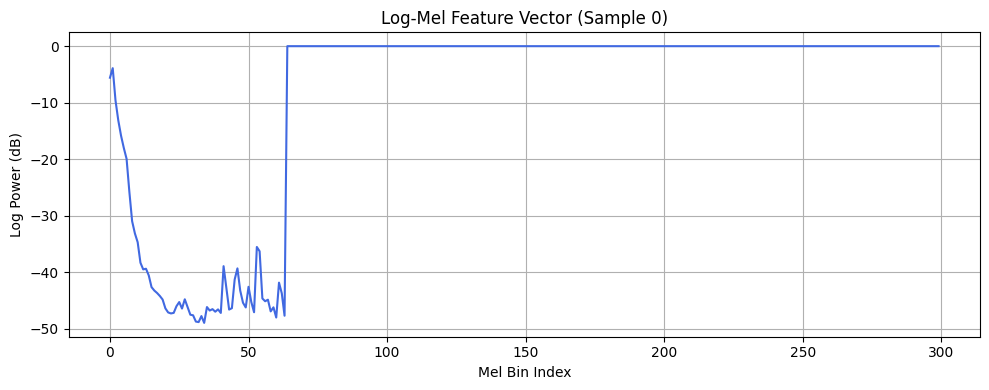

In [6]:
import matplotlib.pyplot as plt

def plot_logmel_feature(X_logmel, index=0):
    plt.figure(figsize=(10, 4))
    plt.plot(X_logmel[index], color='royalblue')
    plt.title(f"Log-Mel Feature Vector (Sample {index})")
    plt.xlabel("Mel Bin Index")
    plt.ylabel("Log Power (dB)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example: Plot sample 0
plot_logmel_feature(X_logmel, index=0)

In [7]:
# === Imports ===
import os
import librosa
import numpy as np
import tqdm
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model

# === Parameters ===
base_dir = "/content/drive/MyDrive/datasets/Cinc"
label_mat_path = "/content/drive/MyDrive/datasets/label_matrix_cinc.mat"
sampling_rate = 2000
n_mels = 64

# === Load labels from .mat file ===
mat = scipy.io.loadmat(label_mat_path)
print("MAT Keys:", [k for k in mat.keys() if not k.startswith("__")])

label_key = 'quality_labels_truncated'  # <-- Adjust if different
label_matrix = mat[label_key].flatten()

# === Get .wav files ===
wav_files = sorted([f for f in os.listdir(base_dir) if f.endswith('.wav')])
assert len(wav_files) == len(label_matrix), f"Mismatch: {len(wav_files)} files vs {len(label_matrix)} labels"

# === Step 1: Extract mel spectrograms ===
X_logmel_2d = []
y_logmel_2d = []
mel_specs = []
max_time_frames = 0

for i, file_name in enumerate(tqdm.tqdm(wav_files, desc="Processing audio")):
    file_path = os.path.join(base_dir, file_name)

    # Load and resample
    signal, sr = librosa.load(file_path, sr=None)
    signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
    signal = signal / np.max(np.abs(signal))  # normalize

    # Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_mels=n_mels)

    # Track max time length
    max_time_frames = max(max_time_frames, mel_spec.shape[1])

    mel_specs.append(mel_spec)
    y_logmel_2d.append(label_matrix[i])

# === Step 2: Pad and convert to log scale ===
for mel_spec in mel_specs:
    pad_width = max_time_frames - mel_spec.shape[1]
    mel_padded = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    logmel_spec = librosa.power_to_db(mel_padded, ref=np.max)
    X_logmel_2d.append(logmel_spec)

# === Convert to arrays ===
X_logmel_2d = np.array(X_logmel_2d)  # shape: (samples, n_mels, time)
y_logmel_2d = np.array(y_logmel_2d)

# === Encode labels ===
unique_labels = np.unique(y_logmel_2d)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
y_logmel_enc = np.array([label_to_index[label] for label in y_logmel_2d])

print("X shape:", X_logmel_2d.shape)
print("y shape:", y_logmel_enc.shape)
print("Label mapping:", label_to_index)

MAT Keys: ['quality_labels_truncated']


Processing audio: 100%|██████████| 3153/3153 [00:41<00:00, 76.05it/s]


X shape: (3153, 64, 398)
y shape: (3153,)
Label mapping: {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4}


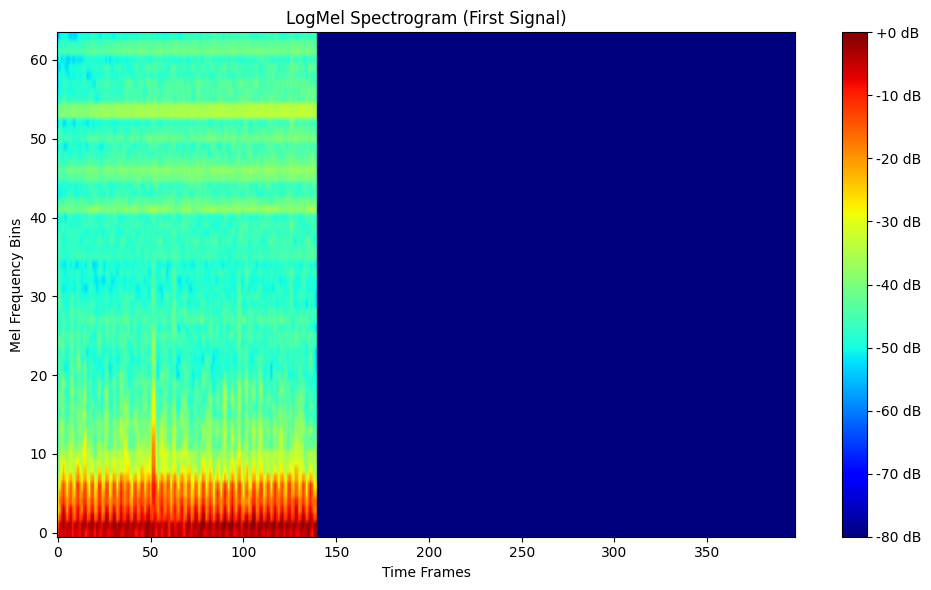

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(X_logmel_2d[0],
           aspect='auto',
           origin='lower',
           cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.title("LogMel Spectrogram (First Signal)")
plt.tight_layout()
plt.show()

In [27]:
import os
import librosa
import numpy as np

# --- Path to your folder with WAV files ---
audio_folder = '/content/drive/MyDrive/datasets/Cinc'  # <- adjust this

# Get list of audio files (sorted for label consistency)
file_list = sorted([f for f in os.listdir(audio_folder) if f.endswith('.wav')])

logmel_features = []

for filename in file_list:
    file_path = os.path.join(audio_folder, filename)

    # Load audio file
    y, sr = librosa.load(file_path, sr=16000)  # You can adjust sr as needed

    # Extract Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)

    # Convert to Log-Mel
    logmel = librosa.power_to_db(mel_spec, ref=np.max)

    # Pad or trim to 128 frames
    if logmel.shape[1] < 128:
        logmel = np.pad(logmel, ((0, 0), (0, 128 - logmel.shape[1])), mode='constant')
    else:
        logmel = logmel[:, :128]

    # Transpose: shape becomes (128, 64)
    logmel_features.append(logmel.T)

# Convert to NumPy array
X = np.array(logmel_features)
print("X shape:", X.shape)  # Should be (num_samples, 128, 64)

# Save for future use
np.save('/content/drive/MyDrive/datasets', X)

X shape: (3153, 128, 64)


In [20]:
from scipy.io import loadmat

mat = loadmat('/content/drive/MyDrive/datasets/label_matrix_cinc.mat')

# Show all keys (filtering internal keys)
keys = [key for key in mat.keys() if not key.startswith('__')]
print("Available keys in labels.mat:", keys)

Available keys in labels.mat: ['quality_labels_truncated']


In [22]:
y = mat['quality_labels_truncated'].squeeze()
print("y shape:", y.shape)

y shape: (3153,)


In [23]:
y = mat['quality_labels_truncated'].squeeze()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# === Load preprocessed data ===
# Replace this with your own file path if needed
X = np.load('/content/drive/MyDrive/datasets')  # (samples, time_steps, mel_bins)
from scipy.io import loadmat
mat = loadmat('/content/drive/MyDrive/datasets/label_matrix_cinc.mat')
y = mat['quality_labels_truncated'].squeeze()  # Replace 'your_label_key' with actual key like 'labels' or 'gt'

# === Normalize features ===
X = X / np.max(X)

# === Convert labels to one-hot ===
if len(y.shape) == 1:
    y = to_categorical(y)
num_classes = y.shape[1]

# === 10-fold cross-validation setup ===
kf = KFold(n_splits=10, shuffle=True, random_state=42)
val_accuracies = []
all_y_true = []
all_y_pred = []

fold = 1
for train_idx, val_idx in kf.split(X):
    print(f"\nTraining Fold {fold}...")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # === Build CNN + GRU model ===
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        Dropout(0.3),
        GRU(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # === Early stopping to prevent overfitting ===
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=30,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[early_stop],
              verbose=0)

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy for Fold {fold}: {val_acc:.4f}")

    # Predict and store for confusion matrix
    y_pred = model.predict(X_val, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    all_y_true.extend(y_true_classes)
    all_y_pred.extend(y_pred_classes)

    fold += 1

# === Report minimum validation accuracy ===
min_val_acc = min(val_accuracies)
print(f"\nMin Validation Accuracy: {min_val_acc:.4f}")

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/datasets'

In [ ]:
# === Plot confusion matrix ===
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (10-Fold CV)")
plt.tight_layout()
plt.show()

# **CNN**

In [18]:
# from sklearn.model_selection import train_test_split

# # Add channel dimension for CNN (samples, n_mels, time, 1)
# # Removed the extra np.newaxis
# X_logmel_2d = X_logmel_2d[..., np.newaxis]  # ✅ shape: (samples, 64, time, 1)
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_logmel_2d, y_logmel_enc, test_size=0.2, random_state=42, stratify=y_logmel_enc
# )

# print("Train shape:", X_train.shape)
# print("Test shape:", X_test.shape)

In [28]:
# === Step 3: Reshape for CNN ===
X_logmel_2d = np.squeeze(X_logmel_2d)            # (samples, n_mels, time)
X_logmel_2d = X_logmel_2d[..., np.newaxis]       # (samples, n_mels, time, 1)

# === Step 4: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_logmel_2d, y_logmel_enc,
    test_size=0.2,
    stratify=y_logmel_enc,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# === Step 5: Build CNN ===
num_classes = len(np.unique(y_train))

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train shape: (2522, 64, 398, 1)
Test shape: (631, 64, 398, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 394, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 197, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 197, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 195, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 97, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 95, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 47, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36096)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │     9,240,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,335,685 (35.61 MB)

 Trainable params: 9,335,493 (35.61 MB)

 Non-trainable params: 192 (768.00 B)

In [30]:
# === Step 6: Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

# # === Step 7: Evaluate ===
# test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
# print(f"\nTest Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
17/79 ━━━━━━━━━━━━━━━━━━━━ 2:29 2s/step - accuracy: 0.2843 - loss: 7.8823

KeyboardInterrupt: 

In [ ]:
# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **GRU -> Flatten -> Dense**

In [ ]:
# === Add channel dimension if needed ===
X = np.squeeze(X_logmel_2d)  # Ensure shape is (samples, n_mels, time)

# Transpose to (samples, time, features) format for GRU
X = np.transpose(X, (0, 2, 1))  # Now shape: (samples, time, n_mels)

# === Train-test split ===
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_logmel_enc,
    test_size=0.2,
    stratify=y_logmel_enc,
    random_state=42
)

print("X_train shape:", X_train.shape)  # Should be (samples, time, n_mels)
print("y_train shape:", y_train.shape)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Flatten

num_classes = len(np.unique(y_train))

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Use sigmoid if binary classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# **Flatten -> GRU -> Dense layer**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure shape: (samples, n_mels, time)
X = np.squeeze(X_logmel_2d)

# Flatten across both mel + time dimensions to feed into GRU
# Instead of transposing for GRU, we flatten first
samples, n_mels, time_steps = X.shape
X_flat = X.reshape((samples, n_mels * time_steps, 1))  # Shape: (samples, sequence_length, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_logmel_enc,
    test_size=0.2,
    stratify=y_logmel_enc,
    random_state=42
)

print("X_train shape:", X_train.shape)  # (samples, sequence_length, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

num_classes = len(np.unique(y_train))

model = Sequential([
    GRU(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Use sigmoid if binary classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
train_accuracy = history.history['accuracy'][-1] * 100

print(f"Final Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Predict classes on test set ===
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === Step 2: Compute confusion matrix ===
cm = confusion_matrix(y_test, y_pred)

# === Step 3: Display confusion matrix ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

# **CNN + Attention Model**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Reshape, Permute, Multiply, Lambda, GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
# === Make sure X is (samples, n_mels, time, 1) ===
X = np.squeeze(X_logmel_2d)
X = X[..., np.newaxis]  # shape: (samples, 64, time, 1)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y_logmel_enc,
    test_size=0.2,
    stratify=y_logmel_enc,
    random_state=42
)

print("X_train shape:", X_train.shape)  # (samples, 64, time, 1)


In [ ]:
from tensorflow.keras.layers import Layer

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


In [ ]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

input_layer = Input(shape=input_shape)

# CNN Block
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

# Reshape for Attention: (batch, time, features)
shape = x.shape
x = Reshape((shape[1]*shape[2], shape[3]))(x)

# Attention
x = Attention()(x)

# Dense Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
